In this file:
- **Get ETF data for the NASDAQ not the price itself!!!**
- Get the price data for the NASDAQ100: Use the closing price, calculate daily returns by taking the log returns (np.log(price).diff())
    - *Q1: Should we take the percentage difference thing instead? like: $(p_t - p_{t-1})/p_{t-1}$*
        - for performance of portfolio: **use real returns not log!!!**
    - *Q2: Should we take the daily difference as p_close - p_open or should it be p_close_today - p_close_yesterday? (currently have today - yesterday)?*
        - **close price good!!!!**

- Get data for the risk free asset: 
    - *Q1: Is the 10 year treasury note appropriate? if so is this data actually the right data?: https://www.investing.com/rates-bonds/us-10-yr-t-note-historical-data*
    Changed to ETF: https://finance.yahoo.com/quote/IEF/history/?period1=1420070400&period2=1577750400
        - could use a 3 month t bill as the risk free asset!! 
        - dont use futures!!!!!!!
        - **OECD.org for t bill data**

- Combine the two as 60/40 portfolio and calculate the returns of the portfolio:
    - *Is it correct to just do r_portfolio = 0.6 * r_ndq + 0.4 * r_rf?*
        - yes correct if we want to rebalance daily (which we do)
    - *When rebalancing the portfolio*: Right now we just calculate this each day (the returns), and count that as rebalancing the portfolio daily, is this correct? Do we need to set some 'budget' or number of shares to invest and allocate daily to have it be a portfolio? Kinda confused about how to construct the portfolio overall and how to rebalance daily.
        - dont need a budget - can just assume the budget is $1 kinda to get an idea (like weight 1/x 1/(1-x)). 
- We want to calculate monthly sharpe ratio:
                $$\text{Sharpe ratio} = (r_{portfolio} - \text{risk free rate})/(\text{standard deviation of portfolio})$$
    - *Q1: Does it make sense to do it montlhy? should it be yearly or something instead?*
        - Yea makes sense but could also calculate rolling window sharpe ratio!!!
        - As a metric to compare portfolio calculate sharpe ratio for the whole period by using mean of all the daily returns and std of all the returns to see how the portfolios performed overall. To get a more detailed look we then look at the rolling window one. 
        - Rolling window: 90 day window
    - *Q2: Do calculate it we need the monthly returns. Whats the best way to calculate them? The two we tried are:*
        **1. Just take the average of the daily returns to get the 'average monthly returns' needed for the sharpe ratio**
        - correct way!!!
        - take the average and then transform to monthly by calculating by 30!! STD to monthly: calculate by sqrt(30)
        - could also do yearly if we want
        2. Caclulate the monthly returns using the following formula:
            - Return = $\Pi$ (Daily growth factor) - 1, where Daily growth factor = 1 + daily return
            - If we use this method, is the return in the daily growth factor still the % return right?
        - Which method is more appropriate? (or neither?)
    - *Q3: For the Sharpe ratio we need the risk free rate, for this we thought to use 1 month US t-bills, is that appropriate?*
        - USE 3 MONTH T-BILL, DONT USE FUTURE, FIND DATA FROM OECD.ORG
        - Additionally: Is it then appropriate to use the GS1M as a proxy? (this data: https://fred.stlouisfed.org/series/GS1M), if not, what is?

        - The yield is on an annual basis (right?), so we need to turn it to a monthly basis for the sharpe ratio calculations (right?). What method is appropriate for this? We tried two: 
            1. Approximation: (yield/12)/100 **<--- good enough!!!**
            2. Formula: $$(1 + \text{yield}/100)^{1/12} - 1$$
            - When we do this the risk free rate is soooo low, does that make sense? over the period the t-bill anual yield is from 0.02%-2.45%, so maybe it does make sense that it's tiny? yea makes sense
            The yield over the period looks like: 
            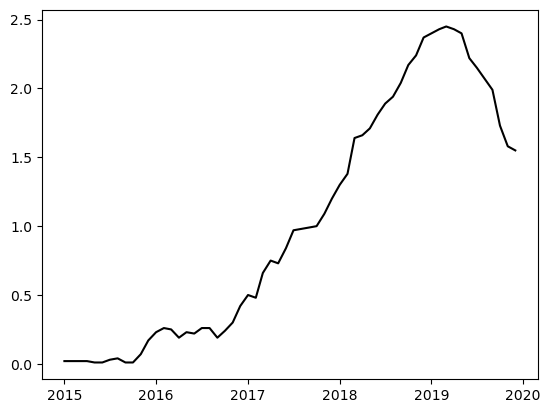 
    - *Q4: For the denumenator we need the standard deviation:*
        - Right now we calculate the monthly standard deviation of each assets based on the daily returns as: np.std(r_ndq) and np.std(r_rf), so we get one number for each month, does this make sense? does this still work if we use the monthly returns based on the growth factor formula instead of just the average monthly returns?
        - Are we supposed to assume that the standard deviation is 0 for the risk free asset? Since it's supposed to be 'risk free'? Because the standard deviation is not 0 when we calculate it...
        - When calculating the standard deviation of the portfolio we use the following formula:
            $$\sigma_{portfolio} = \sqrt{w_{ndq}^2*\sigma_{ndq}^2 + w_{rf}^2*\sigma_{rf}^2 + 2*w_{ndq}*w_{rf}*cov(r_{ndq}, r_{rf})}$$
            Is this correct?
        - do need it to optimize the weights, but if we use t-bills as risk free asset we can assume the std of it is 0!!!!
    - *Q5: Finally, we calculate the sharpe ratio with this info and the resulting monthly sharpe ratio for the 5 year period looks like this: does it look correct? are the fluctuations weird?:* ->>> need to do it all again anyway so doesnt matter but could make sense since its monthly, if we do rolling window then it should be smooth. 
        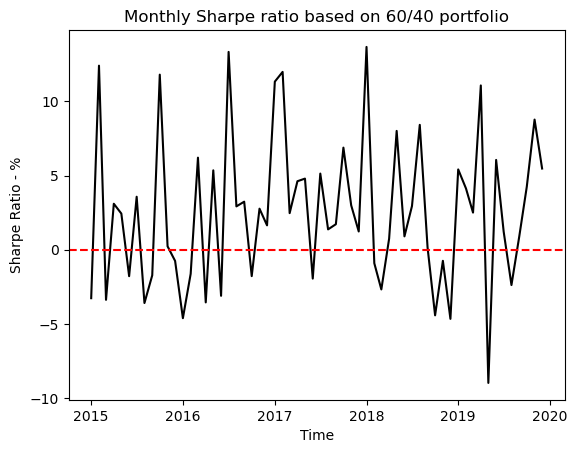
    
- If we want to get just 1 number for each portfolio by calculating the sharpe ratio for the entire period, could we do that by just taking the average of the monthly ones? Or do we need to calculate it all again? or do we calculate the standard deviation based on the monthly returns (np.std(monthly_returns_portfolio)) and then average returns and average risk free rate?
    - No, do the overall sharperatio based on all the daily returns.

Heres a graph summarizing all the inputs for the sharpe and the sharpe itself, does anything look off? does it make sense?: -> do again anyway

Other: What split should we use? 80/20 and then 20/80 for risk off? or 100/0 and 0/100? always 60/40 for neutral?
If we are changing the weights daily based on the volatility index / sentiment index, how would we calculate the monthly standard deviation of the portfolio? Since we dont have constant weights anymore so the formula doesnt work, or would it make sense to just take the average weight for each month as the weight in the formula? Or could we just take the standard deviation of the portfolio returns and not worry about the covariance stuff? (np.std(r_portfolio)) -> think its fine to just use function since wwe have daily portfolio returns based on the weights each day. 

also: returns for just nasdaq higher than the benchmark, so if we have a classifier that tells us to always invest in nasdaq over the period we will get better returns than the benchmark.. will this be an issue? Give misleading results? blahblah its fine

**Regarding sentiment index:**
we have tweets from the weekends, what would be the best way to deal with them? lump them with friday so their sentiment would effect the market on monday? ignore them? or what is the best way to deal with them?
    -> lump with friday



To smooth the asset allocation stuff: try looking at the 5 day or 3 day moving average of the index to not be so extreme everyday, because the trading costs would be so high from selling the entire portfolio basically daily that it would cancel out the profits. 
-> also maybe try finding info about the trading costs and take it into account like subtract it from the portfolio value when we trade. 
-> oqam white paper does similar with the moving average stuff, look into again.

------------------------------------------------------------------------------------------------
Want to calculate the risk adjusted returns for the NASDAQ100 stock over the period we are looking at.
Risk-adjusted returns are a way to assess an investment's performance relative to its risk. One of the most common measures for risk-adjusted returns is the Sharpe ratio.

Formula:
$$\text{Sharpe ratio} = \frac{\text{Risk premium}}{\text{SD of excess return}}$$
that is:
𝑆ℎ𝑎𝑟𝑝𝑒 𝑟𝑎𝑡𝑖𝑜=(𝐸(𝑟_𝐸𝐷 )−𝑟_𝑓)/𝜎_𝐸𝐷 

Sharpe Ratio = (Average Return of Investment - Risk-Free Rate) / Standard Deviation of Investment

First we need the average return, since we want to calculate this daily we can just use the daily return instead of average.
Calculate it using: Daily Return = (Price at Day N - Price at Day N-1) / Price at Day N-1
(so not log return?)

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [138]:
# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,103.760002,104.199997,102.440002,102.940002,95.704712,31314600
1,2015-01-05,102.489998,102.610001,101.139999,101.430000,94.300850,36521300
2,2015-01-06,101.580002,101.750000,99.620003,100.070000,93.036430,66205500
3,2015-01-07,100.730003,101.599998,100.489998,101.360001,94.235786,37577400
4,2015-01-08,102.220001,103.500000,102.110001,103.300003,96.039421,40212600


In [139]:
import pandas as pd

# Calculate real returns
price_df['r_ndq'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1)) / price_df['Adj Close'].shift(1)

# Now price_df includes the new column 'r_ndq' with the real returns
price_df.dropna(inplace=True)
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,r_ndq
1,2015-01-05,102.489998,102.610001,101.139999,101.430000,94.300850,36521300,-0.014669
2,2015-01-06,101.580002,101.750000,99.620003,100.070000,93.036430,66205500,-0.013408
3,2015-01-07,100.730003,101.599998,100.489998,101.360001,94.235786,37577400,0.012891
4,2015-01-08,102.220001,103.500000,102.110001,103.300003,96.039421,40212600,0.019140
5,2015-01-09,103.620003,103.650002,102.019997,102.620003,95.407211,41410100,-0.006583


Portfolio: use model to rebalance every day, and then calculate monthly sharpe ratio to compare the two portfolios (ours and the benchmark)

Steps we need:
- Add risk free returns to the data
- Calculate the returns for the benchmark portfolio
    - To do that: w_rf = 0.4, w_s = 0.6, r_bm = w_rf*r_rf + w_s *r_s
    - calculate them daily and then calculate monthly sharpe ratio:
        - to do that: Get monthly standard deviation -> based on date column 
        - get average monthly return for both the portfolio and just the risk free
        - calculate risk premium (r_bm - r_rf)
        - calculate sharpe ratio: risk premium / std_bm

**1. Get rf data:**

- 1. Load the data
- 2. Calculate daily returns
- 3. Add to dataframe (or make new dataframe with just the relevant info)


Here I download data from https://finance.yahoo.com/quote/IEF/history/?period1=1420070400&period2=1577750400
that is, it's data about the price of an ETF of 7-10 year US treasury note I think.

In [140]:
rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/IEF.csv')

In [141]:

# Calculate real returns
rf_df['r_rf'] = (rf_df['Adj Close'] - rf_df['Adj Close'].shift(1)) / rf_df['Adj Close'].shift(1)

# Now price_df includes the new column 'r_ndq' with the real returns

rf_df.dropna(inplace=True)

In [142]:
rf_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,r_rf
1,2015-01-05,106.709999,107.250000,106.660004,107.180000,90.140625,1521700,0.006101
2,2015-01-06,107.629997,108.470001,107.529999,107.900002,90.746216,1890200,0.006718
3,2015-01-07,107.589996,108.010002,107.459999,107.879997,90.729355,1558000,-0.000186
4,2015-01-08,107.529999,107.570000,107.309998,107.440002,90.359299,1671000,-0.004079
5,2015-01-09,107.570000,108.099998,107.459999,107.970001,90.805046,1107800,0.004933


In [143]:
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

**2. Calculate daily 60/40 portfolio returns**
- Use w_rf*r_rf + w_nq+r_nq

In [144]:
benchmark6040_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

benchmark6040_df.head()

,Date,r_ndq,r_rf
0,2015-01-05,-0.014669,0.006101
1,2015-01-06,-0.013408,0.006718
2,2015-01-07,0.012891,-0.000186
3,2015-01-08,0.019140,-0.004079
4,2015-01-09,-0.006583,0.004933


In [145]:
w_rf = 0.4
w_ndq = 0.6

In [146]:
benchmark6040_df['r_bm'] = w_rf*benchmark6040_df['r_rf'] + w_ndq*benchmark6040_df['r_ndq']

In [147]:
benchmark6040_df.head()

,Date,r_ndq,r_rf,r_bm
0,2015-01-05,-0.014669,0.006101,-0.006361
1,2015-01-06,-0.013408,0.006718,-0.005358
2,2015-01-07,0.012891,-0.000186,0.007660
3,2015-01-08,0.019140,-0.004079,0.009852
4,2015-01-09,-0.006583,0.004933,-0.001976


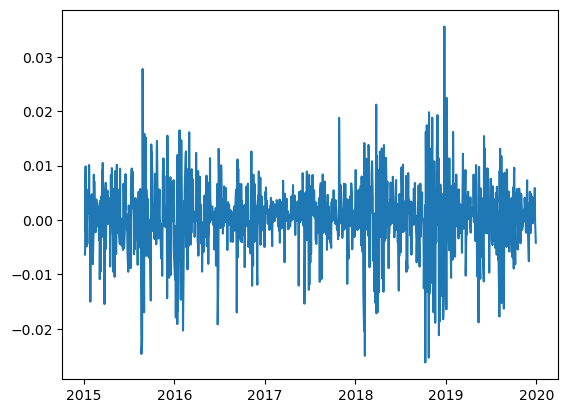

In [148]:
plt.plot(benchmark6040_df['Date'], benchmark6040_df['r_bm'])

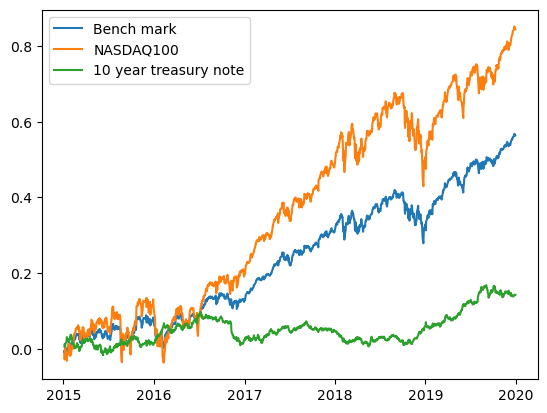

In [149]:
values_bm = benchmark6040_df['r_bm'].cumsum()
values_ndq = benchmark6040_df['r_ndq'].cumsum()
values_rf = benchmark6040_df['r_rf'].cumsum()

plt.plot(benchmark6040_df['Date'], values_bm, label='Bench mark')
plt.plot(benchmark6040_df['Date'], values_ndq, label='NASDAQ100')
plt.plot(benchmark6040_df['Date'], values_rf, label = '10 year treasury note')
plt.legend()

Final value of portfolio:  175.673433159978


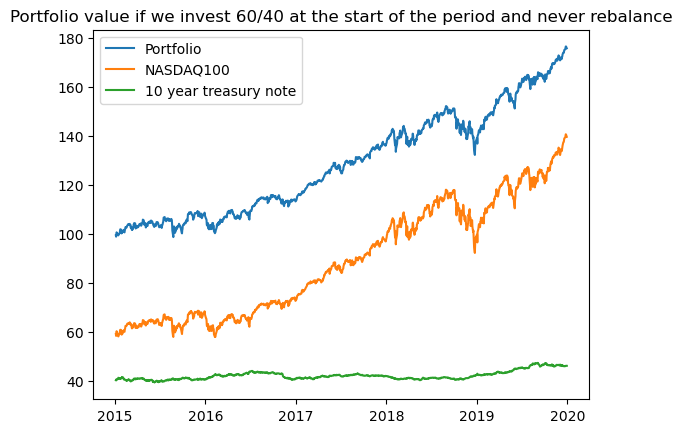

In [150]:
P = 60
history_ndq = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_ndq'][i])
    history_ndq.append(P)
    

P = 40
history_rf = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_rf'][i])
    history_rf.append(P)


P = 100
history_bm = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_bm'][i])
    history_bm.append(P)

print('Final value of portfolio: ', P)

plt.plot(benchmark6040_df['Date'], history_bm[1:], label='Portfolio')
plt.plot(benchmark6040_df['Date'], history_ndq[1:], label='NASDAQ100')
plt.plot(benchmark6040_df['Date'], history_rf[1:], label = '10 year treasury note')
plt.title('Portfolio value if we invest 60/40 at the start of the period and never rebalance')
plt.legend()

**3. Get the risk free rate**

In [151]:
r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/risk_free_rate.csv')
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
r_rf_df.head()

,Unnamed: 0,Date,rf_rate
0,250,2015-01-02,0.02
1,249,2015-01-05,0.03
2,248,2015-01-06,0.03
3,247,2015-01-07,0.03
4,246,2015-01-08,0.03


In [152]:
# add it do the benchmark dataframe:
benchmark6040_df = pd.merge(benchmark6040_df, r_rf_df[['Date', 'rf_rate']], on = 'Date', how = 'inner')
benchmark6040_df.head()

,Date,r_ndq,r_rf,r_bm,rf_rate
0,2015-01-05,-0.014669,0.006101,-0.006361,0.03
1,2015-01-06,-0.013408,0.006718,-0.005358,0.03
2,2015-01-07,0.012891,-0.000186,0.007660,0.03
3,2015-01-08,0.019140,-0.004079,0.009852,0.03
4,2015-01-09,-0.006583,0.004933,-0.001976,0.02


**4. Calculate the monthly returns and standard devitations for the Sharpe ratio**

In [153]:
# Set 'Date' as the index of the DataFrame
benchmark6040_df.set_index('Date', inplace=True)

# Resample the data by month and calculate mean and standard deviation for specific columns
monthly_stats = benchmark6040_df.resample('M').agg({
    'r_ndq': ['mean', 'std'],
    'r_rf': ['mean', 'std'],
    'r_bm': 'mean',
    'rf_rate': 'mean',
    })


# Flatten the MultiIndex in columns created by agg()
monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

grouped = benchmark6040_df.resample('M')
covariances = []
for month in grouped:
    cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
    row = {'Date': month[0], 'covariance': cov}
    covariances.append(row)

covariances = pd.DataFrame(covariances)
covariances.set_index('Date', inplace=True)

# Combine the results
monthly_stats = pd.concat([monthly_stats, covariances], axis=1)

print(monthly_stats)


            r_ndq_mean  r_ndq_std  r_rf_mean  r_rf_std  r_bm_mean  \
Date                                                                
2015-01-31   -0.000878   0.012226   0.001963  0.004968   0.000258   
2015-02-28    0.003692   0.005876  -0.001306  0.004673   0.001693   
2015-03-31   -0.001044   0.009247   0.000398  0.004771  -0.000467   
2015-04-30    0.000937   0.007955  -0.000298  0.002891   0.000443   
2015-05-31    0.001147   0.008553  -0.000198  0.004622   0.000609   
2015-06-30   -0.001110   0.008247  -0.000733  0.005368  -0.000959   
2015-07-31    0.002067   0.009047   0.000692  0.003892   0.001517   
2015-08-31   -0.003168   0.020094   0.000044  0.003795  -0.001883   
2015-09-30   -0.000942   0.015903   0.000754  0.004053  -0.000263   
2015-10-31    0.005067   0.009514  -0.000458  0.003528   0.002857   
2015-11-30    0.000421   0.008769  -0.000198  0.002309   0.000173   
2015-12-31   -0.000654   0.012658  -0.000198  0.004285  -0.000471   
2016-01-31   -0.003590   0.019009 

In [154]:
monthly_stats.head()

,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance
Date,,,,,,,
2015-01-31,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041
2015-02-28,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005
2015-03-31,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013
2015-04-30,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003
2015-05-31,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004


In [155]:
#add risk free rate on monthly basis to data:

monthly_stats['risk_free_rate_m'] = (1+(monthly_stats['rf_rate_mean']/100))**(1/12) - 1

In [156]:
#calculate standard deviation of the portfolio per month:

monthly_stats['std_bm'] = np.sqrt(w_ndq**2*monthly_stats['r_ndq_std']**2 + w_rf**2*monthly_stats['r_rf_std']**2 + 2*w_ndq*w_rf*monthly_stats['covariance'])

monthly_stats.head()

,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance,risk_free_rate_m,std_bm
Date,,,,,,,,,
2015-01-31,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041,0.000023,0.006184
2015-02-28,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005,0.000015,0.003701
2015-03-31,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013,0.000023,0.006380
2015-04-30,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003,0.000019,0.004771
2015-05-31,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004,0.000014,0.005613


In [157]:
monthly_stats = monthly_stats.reset_index()
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance,risk_free_rate_m,std_bm
0,2015-01-31,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041,0.000023,0.006184
1,2015-02-28,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005,0.000015,0.003701
2,2015-03-31,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013,0.000023,0.006380
3,2015-04-30,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003,0.000019,0.004771
4,2015-05-31,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004,0.000014,0.005613


In [158]:

# Change index to the first of each month
monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
monthly_stats.head()


,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance,risk_free_rate_m,std_bm
0,2015-01-01,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041,0.000023,0.006184
1,2015-02-01,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005,0.000015,0.003701
2,2015-03-01,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013,0.000023,0.006380
3,2015-04-01,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003,0.000019,0.004771
4,2015-05-01,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004,0.000014,0.005613


In [159]:
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance,risk_free_rate_m,std_bm
0,2015-01-01,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041,0.000023,0.006184
1,2015-02-01,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005,0.000015,0.003701
2,2015-03-01,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013,0.000023,0.006380
3,2015-04-01,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003,0.000019,0.004771
4,2015-05-01,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004,0.000014,0.005613


In [160]:
monthly_stats['Date'].dtype

dtype('O')

**5. Finally: calculate the monthly sharpe ratio for the benchmark portfolio:**

In [161]:
monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance,risk_free_rate_m,std_bm
0,2015-01-01,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041,0.000023,0.006184
1,2015-02-01,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005,0.000015,0.003701
2,2015-03-01,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013,0.000023,0.006380
3,2015-04-01,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003,0.000019,0.004771
4,2015-05-01,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004,0.000014,0.005613


In [162]:
monthly_stats['risk_premium'] = monthly_stats['r_bm_mean']*30 - monthly_stats['risk_free_rate_m']

#sharpe_bm = risk_premium / monthly_stats['std_bm']

In [163]:
monthly_stats['sharpe_ratio'] = monthly_stats['risk_premium']/(monthly_stats['std_bm']*np.sqrt(30))
#*100 because we didnt make it into percentages yet!
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,rf_rate_mean,covariance,risk_free_rate_m,std_bm,risk_premium,sharpe_ratio
0,2015-01-01,-0.000878,0.012226,0.001963,0.004968,0.000258,0.027895,-0.000041,0.000023,0.006184,0.007732,0.228252
1,2015-02-01,0.003692,0.005876,-0.001306,0.004673,0.001693,0.017895,-0.000005,0.000015,0.003701,0.050776,2.504497
2,2015-03-01,-0.001044,0.009247,0.000398,0.004771,-0.000467,0.027727,0.000013,0.000023,0.006380,-0.014026,-0.401377
3,2015-04-01,0.000937,0.007955,-0.000298,0.002891,0.000443,0.023333,-0.000003,0.000019,0.004771,0.013272,0.507887
4,2015-05-01,0.001147,0.008553,-0.000198,0.004622,0.000609,0.016500,0.000004,0.000014,0.005613,0.018253,0.593686


Text(0.5, 1.0, 'Monthly Sharpe ratio based on 60/40 portfolio')

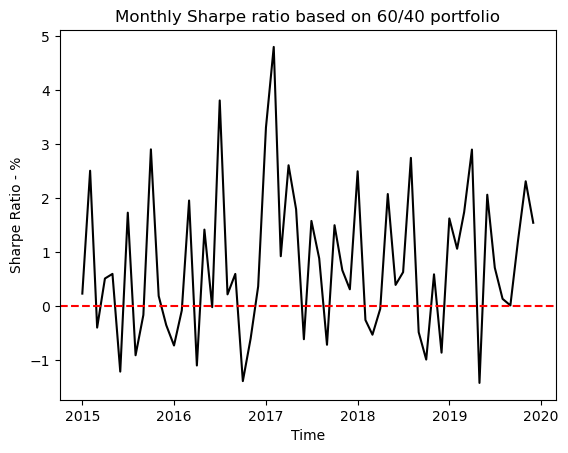

In [164]:
plt.plot(monthly_stats['Date'], monthly_stats['sharpe_ratio'], color = 'black')
plt.xlabel('Time')
plt.ylabel('Sharpe Ratio - %')
plt.axhline(0, color = 'red', linestyle = '--')
plt.title('Monthly Sharpe ratio based on 60/40 portfolio')

In [165]:
np.average(monthly_stats['sharpe_ratio'])

0.7760498269434877

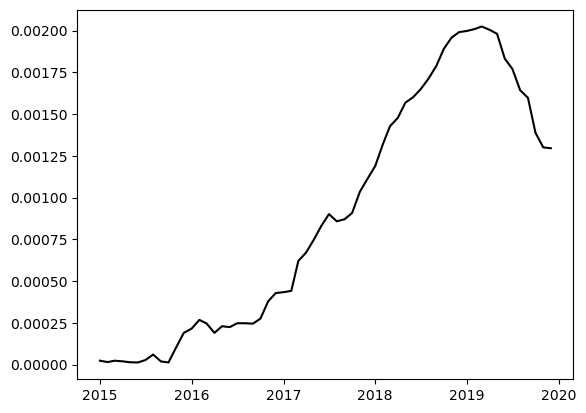

In [166]:
plt.plot(monthly_stats['Date'], monthly_stats['risk_free_rate_m'], color = 'black')
#plt.plot(sharpe_df['Date'], sharpe_df['monthly_returns_bm']*100)

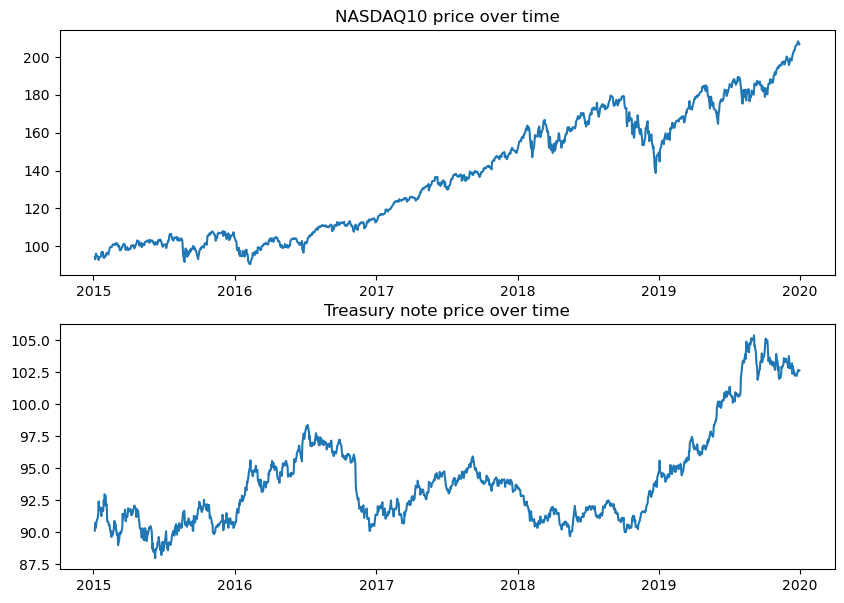

In [167]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('NASDAQ10 price over time')
plt.plot(price_df['Date'], price_df['Adj Close'])
plt.subplot(2,1,2)
plt.title('Treasury note price over time')
plt.plot(rf_df['Date'], rf_df['Adj Close'])

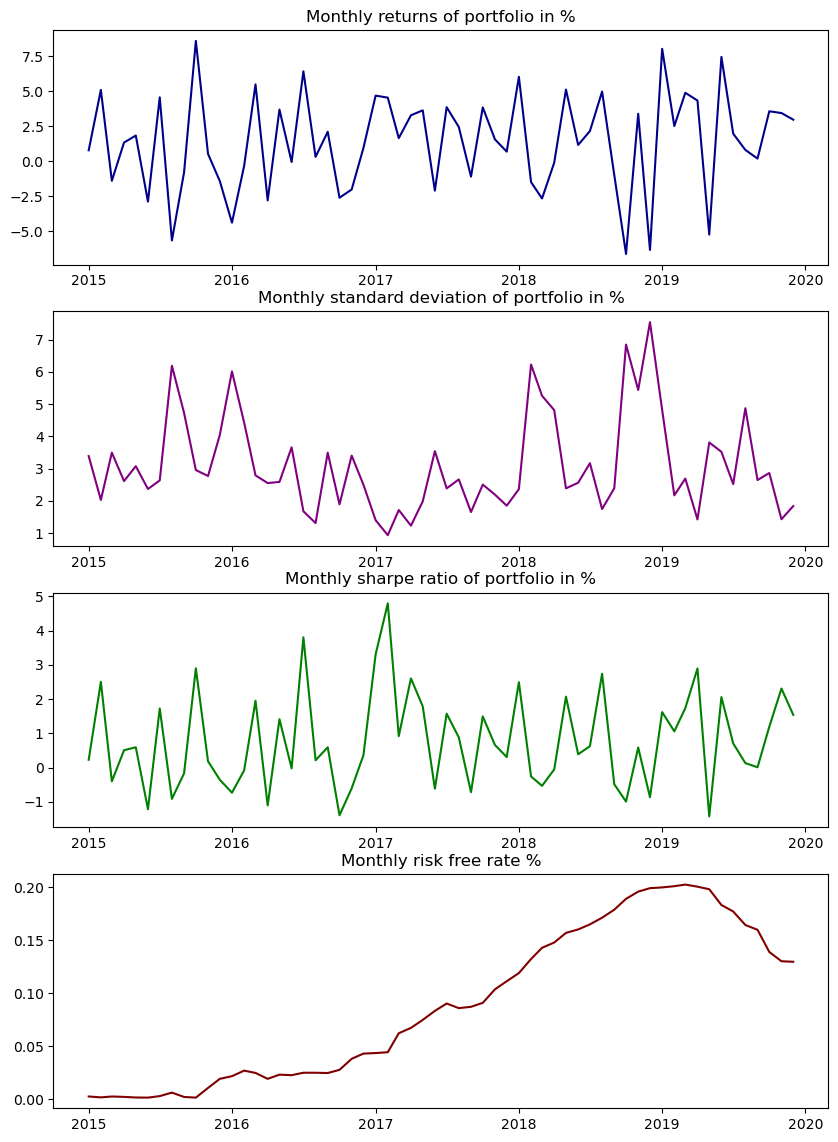

In [168]:
plt.figure(figsize=(10,14))
plt.subplot(4,1,1)
plt.title('Monthly returns of portfolio in %')
plt.plot(monthly_stats['Date'], monthly_stats['r_bm_mean']*30*100, color = 'darkblue')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(4,1,2)
plt.title('Monthly standard deviation of portfolio in %')
plt.plot(monthly_stats['Date'], monthly_stats['std_bm']*np.sqrt(30)*100, color = 'purple')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(4,1,3)
plt.title('Monthly sharpe ratio of portfolio in %')
plt.plot(monthly_stats['Date'], monthly_stats['sharpe_ratio'], color = 'green')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(4,1,4)
plt.title('Monthly risk free rate %')
plt.plot(monthly_stats['Date'], monthly_stats['risk_free_rate_m']*100, color = 'maroon')
#plt.axhline(0, color = 'red', linestyle = '--')



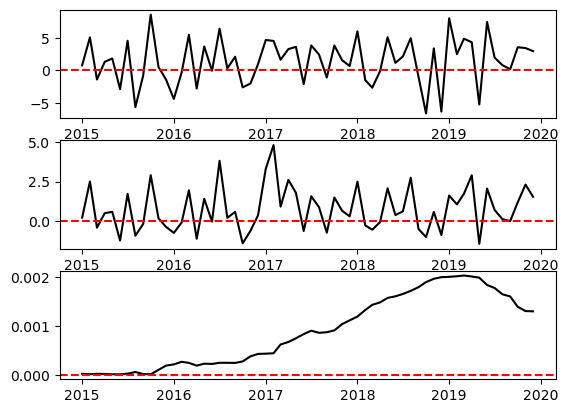

In [169]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(monthly_stats['Date'], monthly_stats['r_bm_mean']*100*30, color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

#plt.subplot(3,1,2)
#plt.plot(sharpe_df['Date'], sharpe_df['monthly_returns_bm'], color = 'black')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(3,1,2)
plt.plot(monthly_stats['Date'], monthly_stats['sharpe_ratio'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(3,1,3)
plt.plot(monthly_stats['Date'], monthly_stats['risk_free_rate_m'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

In [170]:
np.average(monthly_stats['sharpe_ratio'])

0.7760498269434877

In [171]:
std_ndq_m = np.std(monthly_stats['r_ndq_mean'])
std_rf_m = np.std(monthly_stats['r_rf_mean'])
cov_m = np.cov(monthly_stats['r_ndq_mean'], monthly_stats['r_rf_mean'])[0,1]

std_bm_m = np.sqrt(w_ndq**2 * std_ndq_m + w_rf**2 * std_rf_m + 2*w_ndq*w_rf*cov_m) 

average_return = np.average(monthly_stats['r_bm_mean']*100)
rf_return = np.average(monthly_stats['risk_free_rate_m'])

sharpe_total = (average_return*30-rf_return)/(std_bm_m*np.sqrt(30))

sharpe_total

8.714029661765856

In [172]:
benchmark6040_df['r_bm'].sum()

0.5794176876527999

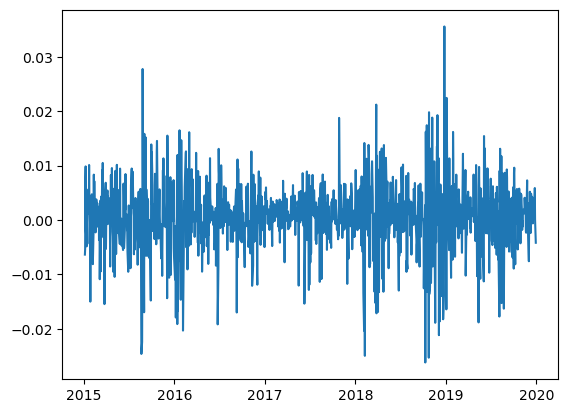

In [173]:
plt.plot(benchmark6040_df['r_bm'])

overall sharpe:

In [180]:
risk_prem = benchmark6040_df['r_bm'].mean() - (benchmark6040_df['rf_rate']/100/252).mean()
std_bm = np.std(benchmark6040_df['r_bm'])
overall_sharpe = risk_prem/std_bm *100
overall_sharpe

6.801011809087905

100% nasdaq sharpe:

In [183]:
risk_prem_ndq = benchmark6040_df['r_ndq'].mean() - r_rf_df['rf_rate'].mean()/252/100
std_ndq_port = np.std(benchmark6040_df['r_ndq'])
overall_sharpe_ndq = risk_prem_ndq/std_ndq_port *100
overall_sharpe_ndq

6.094615708554443

**Try rolling window for daily sharpe ratio over the whole period:**

In [114]:
benchmark6040_df.columns

Index(['r_ndq', 'r_rf', 'r_bm', 'rf_rate'], dtype='object')

In [118]:

# Step 1: Convert annual risk-free rate to daily risk-free rate
benchmark6040_df['daily_rf'] = (1 + benchmark6040_df['rf_rate']/100) ** (1/365) - 1

# Step 2: Calculate excess returns
benchmark6040_df['excess_returns'] = benchmark6040_df['r_bm'] - benchmark6040_df['daily_rf']

# Step 3: Calculate the rolling standard deviation of excess returns over a 90-day window
benchmark6040_df['rolling_std'] = benchmark6040_df['excess_returns'].rolling(window=90).std()

# Step 4: Calculate the mean of excess returns over the same 90-day window
benchmark6040_df['rolling_mean'] = benchmark6040_df['excess_returns'].rolling(window=90).mean()

# Calculate Sharpe Ratio
benchmark6040_df['sharpe_ratio'] = benchmark6040_df['rolling_mean'] / benchmark6040_df['rolling_std']


Text(0.5, 1.0, '90 day rolling window standard deviation of benchmark returns')

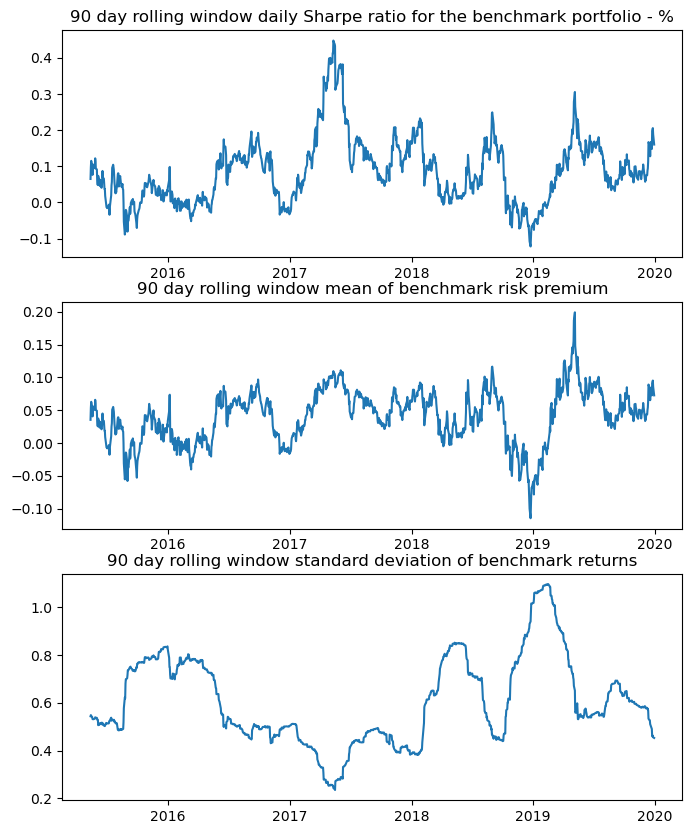

In [136]:
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(benchmark6040_df['sharpe_ratio'])
plt.title('90 day rolling window daily Sharpe ratio for the benchmark portfolio')

plt.subplot(3,1,2)
plt.plot(benchmark6040_df['rolling_mean']*100)
plt.title('90 day rolling window mean of benchmark risk premium')

plt.subplot(3,1,3)
plt.plot(benchmark6040_df['rolling_std']*100)
plt.title('90 day rolling window standard deviation of benchmark returns')


#### Want to just calculate the sharpe for the test period (2019), not the whole period, so do that now:

In [184]:
benchmark6040_df

,r_ndq,r_rf,r_bm,rf_rate
Date,,,,
2015-01-05,-0.014669,0.006101,-0.006361,0.03
2015-01-06,-0.013408,0.006718,-0.005358,0.03
2015-01-07,0.012891,-0.000186,0.007660,0.03
2015-01-08,0.019140,-0.004079,0.009852,0.03
2015-01-09,-0.006583,0.004933,-0.001976,0.02
...,...,...,...,...
2019-12-23,0.002641,-0.000906,0.001222,1.59
2019-12-24,0.000519,0.001724,0.001001,1.58
2019-12-26,0.008824,0.001450,0.005874,1.58


In [187]:
data2019 = benchmark6040_df['2019-01-01':]

In [188]:
data2019

,r_ndq,r_rf,r_bm,rf_rate
Date,,,,
2019-01-02,0.004019,0.002111,0.003256,2.42
2019-01-03,-0.032670,0.007948,-0.016423,2.41
2019-01-04,0.042785,-0.008076,0.022441,2.42
2019-01-07,0.011906,-0.002778,0.006032,2.46
2019-01-08,0.009045,-0.002497,0.004428,2.46
...,...,...,...,...
2019-12-23,0.002641,-0.000906,0.001222,1.59
2019-12-24,0.000519,0.001724,0.001001,1.58
2019-12-26,0.008824,0.001450,0.005874,1.58


In [189]:
risk_prem = data2019['r_bm'].mean() - (data2019['rf_rate']/100/252).mean()
std_bm = np.std(data2019['r_bm'])
overall_sharpe = risk_prem/std_bm *100
overall_sharpe

15.261359040676803